In [1]:
# Clone from GitHub
!git clone https://github.com/ajhglez99/rest_mex_2023_clustering_task.git
!unzip "/content/rest_mex_2023_clustering_task/datasets/dataset_cleaned.zip"

Cloning into 'rest_mex_2023_clustering_task'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 26 (delta 8), reused 15 (delta 5), pack-reused 8
Unpacking objects: 100% (26/26), 88.34 MiB | 8.69 MiB/s, done.
Archive:  /content/rest_mex_2023_clustering_task/datasets/dataset_cleaned.zip
  inflating: dataset_cleaned.csv     


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


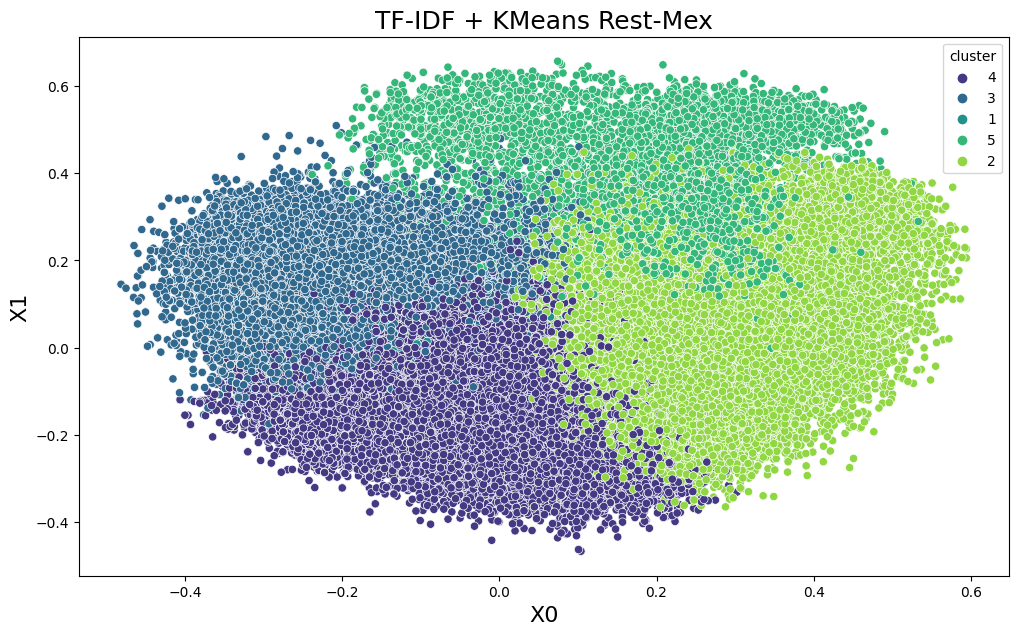

   ID                                               News cluster        x0  \
0   0  marzo firma alianza estrategica uanl otorgara ...       4 -0.068867   
1   1  secciones amenaza tiroteo escuela san nicolas ...       3 -0.223618   
2   2  amenaza tiroteo secundaria nl moviliza autorid...       3 -0.216207   
3   3  amenaza tiroteo alarma papas secundaria san ni...       4 -0.126230   
4   4  tendencias mercados foto shutterstock lunes ma...       4  0.014851   

         x1  
0 -0.206164  
1  0.141242  
2  0.062229  
3  0.019218  
4 -0.159454  


In [3]:
# import the dataset from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# viz libs
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
# import text_preprocess


def tf_idf_vectorization(df):
    # initialize the vectorizer
    vectorizer = TfidfVectorizer(min_df=5, max_df=0.66)
    # fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
    X = vectorizer.fit_transform(df['News'].astype('U').values)

    return X


def lsa_func(X_tfidf):
    lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
    #t0 = time()
    X_lsa = lsa.fit_transform(X_tfidf)
    #explained_variance = lsa[0].explained_variance_ratio_.sum()

    #print(f"LSA done in {time() - t0:.3f} s")
    #print(
    #    f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

    return X_lsa


def text_clustering(df, X):
    # initialize kmeans with 3 centroids
    kmeans = KMeans(n_clusters=5, random_state=42, max_iter=100)
    # fit the model
    kmeans.fit(X)
    # store cluster labels in a variable
    clusters = kmeans.labels_

    # dimensional_reduction
    # initialize PCA with 2 components
    pca = PCA(n_components=2, random_state=42)
    # pass our X to the pca and store the reduced vectors into pca_vecs
    pca_vecs = pca.fit_transform(X)
    # save our two dimensions into x0 and x1
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]

    # assign clusters and PCA vectors to columns in the original dataframe
    df['cluster'] = clusters
    df['x0'] = x0
    df['x1'] = x1

    # map clusters to appropriate labels
    cluster_map = {0: "1", 1: "2", 2: "3", 3: "4", 4: "5"}
    # apply mapping
    df['cluster'] = df['cluster'].map(cluster_map)

    return df


def vizualice(df):
    # set image size
    plt.figure(figsize=(12, 7))
    # set a title
    plt.title("TF-IDF + KMeans Rest-Mex",
              fontdict={"fontsize": 18})
    # set axes names
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})
    # create scatter plot with seaborn, where hue is the class used to group the data
    sns.scatterplot(data=df, x='x0', y='x1', hue='cluster', palette="viridis")
    plt.show()


if __name__ == "__main__":
    df = pd.read_csv('/content/dataset_cleaned.csv')
    # df = pd.read_csv('./datasets/dataset_translated.csv')

    # df['News'] = df['News'].apply(
    #    lambda x: text_preprocess.preprocess(x, remove_stopwords=True))

    X = tf_idf_vectorization(df)
    X_lsa = lsa_func(X)
    df_clustered = text_clustering(df, X_lsa)
    vizualice(df_clustered)

    print(df_clustered.head())

    df_clustered['task'] = 'thematic'
    df_clustered = df_clustered[['task', 'ID','cluster']]
    df_clustered.to_csv(
        '/content/dataset_classified.txt', header=None, index=None, sep='\t')
